In [14]:
# %matplotlib widget

import os
import pandas as pd
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
import seaborn as sns
import wave
import contextlib

# 1. Preprocessing


In [3]:
ravdess_data = "data/RAVDESS/Speech/"

In [68]:
def extract_labels(file_name:str)->int:
    parts = file_name.split('-')
    emotion = int(parts[2])  # Emotion is the third part
    return emotion

def label_to_emotion(label:int)->str:
    if label == 1:
        return "neutral"
    elif label == 2:
        return "calm"
    elif label == 3:
        return "happy"
    elif label == 4:
        return "sad"
    elif label == 5:
        return "angry"
    elif label == 6:
        return "fearful"
    elif label == 7:
        return "disgust"
    elif label == 8:
        return "surprised"
    else:
        return "unknown"

def create_dataframe(directory:str)->pd.DataFrame:
    data = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                label = extract_labels(file)
                emotion = label_to_emotion(label)
                data.append({"FilePath": file_path, "Emotion": emotion, "Label": label})
    df = pd.DataFrame(data)
    return df

In [69]:
dataframe = create_dataframe(ravdess_data)

In [6]:
dataframe.head()

,FilePath,Emotion,Label
0,data/RAVDESS/Speech/Actor_16/03-01-05-01-02-01...,angry,5
1,data/RAVDESS/Speech/Actor_16/03-01-06-01-02-02...,fearful,6
2,data/RAVDESS/Speech/Actor_16/03-01-06-02-01-02...,fearful,6
3,data/RAVDESS/Speech/Actor_16/03-01-05-02-01-01...,angry,5
4,data/RAVDESS/Speech/Actor_16/03-01-07-01-01-01...,disgust,7


In [7]:
print(dataframe.Emotion.value_counts())


Emotion
angry        192
fearful      192
disgust      192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


# 2. Data Visualisation and Exploration

In [8]:
dataframe.count()

FilePath    1440
Emotion     1440
Label       1440
dtype: int64

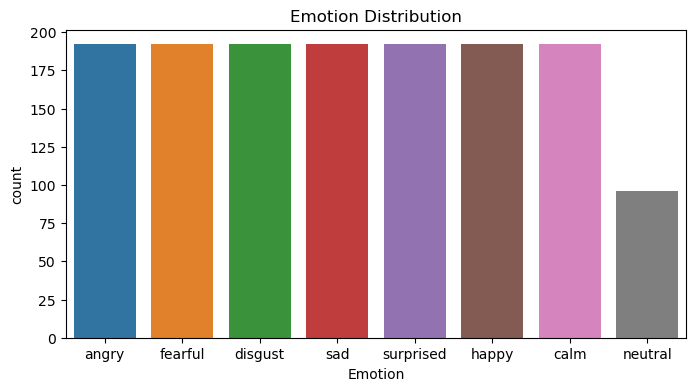

In [9]:
plt.figure(figsize=(8, 4))
sns.countplot(data=dataframe, x="Emotion")
plt.title("Emotion Distribution")
plt.show()

**Check the sampling rate of one random file to make sure it is the same as the one mentioned on the database website.**

In [10]:
sampling_rate = 0
with contextlib.closing(wave.open(dataframe.FilePath[6], 'r')) as wav_file:
    sampling_rate = wav_file.getframerate()
    print(f"Sampling rate: {sampling_rate} Hz")

Sampling rate: 48000 Hz


In [11]:
def load_audio(file_path:str)-> np.ndarray:
    audio, _ = librosa.load(file_path, sr=sampling_rate)
    return audio

In [70]:
def plot_audio(audio:np.ndarray):
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(audio, sr=sampling_rate)
    plt.grid()
    plt.show()

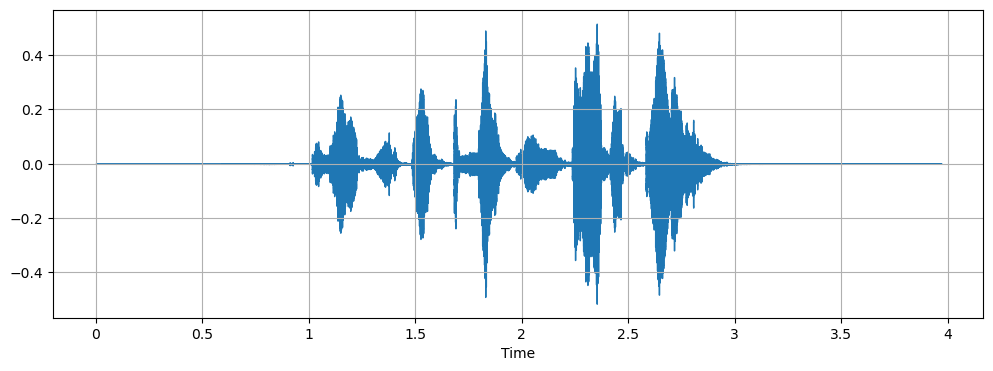

In [71]:
test_audio = load_audio(dataframe.FilePath[3])
plot_audio(test_audio)



# 3. Feature Extraction

### 3.1 Mel-Frequency Cepstral Coefficients (MFCCs)

In [90]:
def extract_mfcc(audio_path:str, sr:float=48000, n_mfcc:int=40,show_plot:bool=False):
    audio = load_audio(audio_path)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    if show_plot:
        librosa.display.specshow(mfcc, x_axis='time')
        plt.ylabel('MFCC')
        plt.colorbar()  
    return np.mean(mfcc.T, axis=0) 

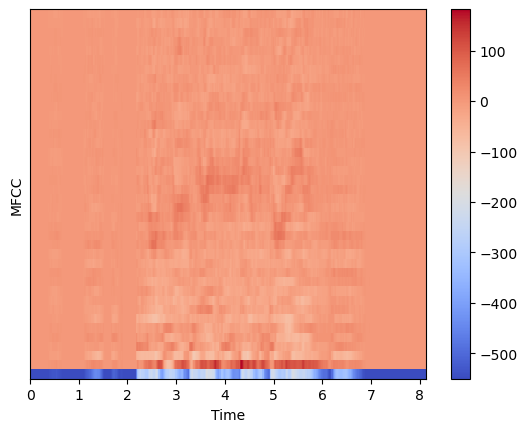

In [91]:
mfcc = extract_mfcc(dataframe.FilePath[2],show_plot=True)


In [64]:
mfcc.shape

(40,)

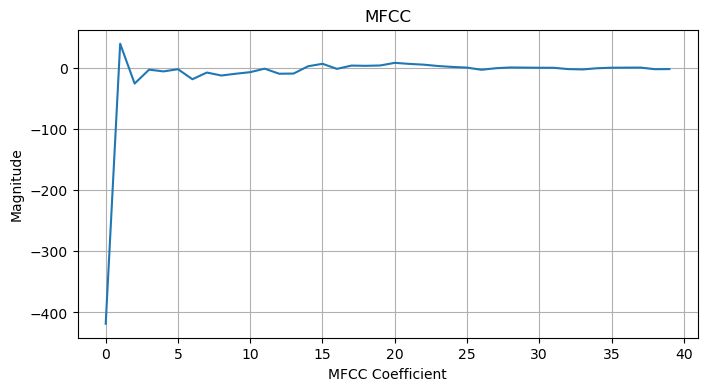

In [66]:
plt.figure(figsize=(8, 4))
plt.plot(mfcc)
plt.title("MFCC")
plt.xlabel("MFCC Coefficient")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

### 3.2 Log-Mel Spectrogram

In [102]:
def extract_logmel(audio_path:str, sr:float=48000, n_mels:int=128,show_plot:bool=False):
    audio= load_audio(audio_path)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    logmel = librosa.power_to_db(mel_spectrogram)
    if show_plot:
        plt.figure(figsize=(8, 4))
        librosa.display.specshow(logmel, y_axis='mel', sr=sampling_rate, x_axis='time');
        print(logmel.shape)
        plt.title('Mel Spectrogram ')
        plt.colorbar(format='%+2.0f dB')

    return logmel.mean(axis=1)  # Mean across time frames


(128, 351)
(128, 304)


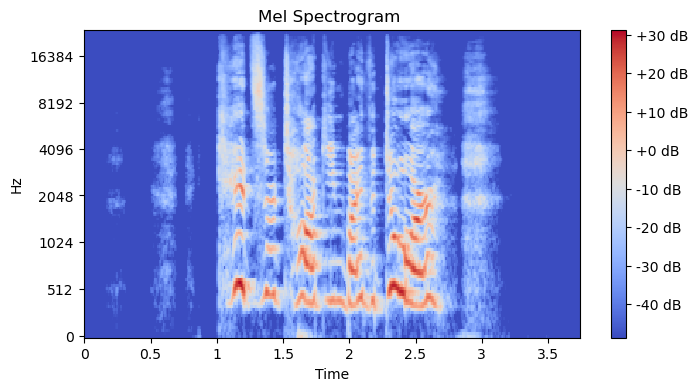

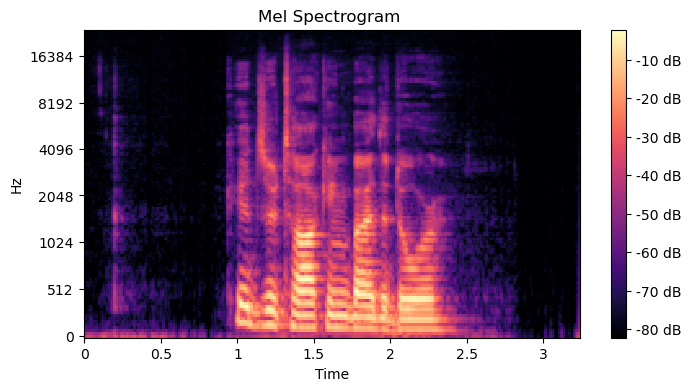

In [103]:
logmel = extract_logmel(dataframe.FilePath[2],show_plot=True)
logmel3 = extract_logmel(dataframe.FilePath[300],show_plot=True)

In [73]:
logmel.shape

(128,)

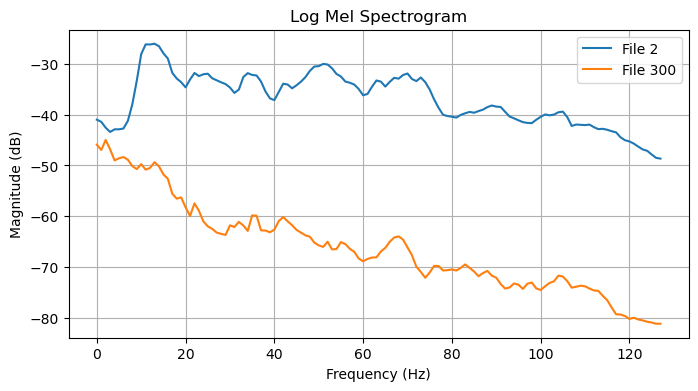

In [101]:
plt.figure(figsize=(8, 4))
plt.plot(logmel, label="File 2")
plt.plot(logmel3, label="File 300")
plt.title("Log Mel Spectrogram")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.legend()
plt.grid()
plt.show()

### 3.3 Prosodic Features (Pitch, Intensity, Duration)

In [134]:
def extract_prosodic(audio_path:str, sr:float=48000) -> list:
    audio = load_audio(audio_path)
    # Pitch (F0)
    pitches = librosa.yin(audio, fmin=50, fmax=260)
    pitch_mean = pitches.mean()

    # Intensity (Energy)
    energy = np.sqrt(np.mean(audio**2))

    # Duration (Voiced regions)
    voiced_frames = librosa.effects.split(audio, top_db=35)
    duration = sum((v[1] - v[0]) for v in voiced_frames) / sr
    return [pitch_mean, energy, duration]


In [135]:
prosodic_features = extract_prosodic(dataframe.FilePath[2])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 169.65 Hz
Energy: 0.08
Duration: 1.87 seconds


In [136]:
prosodic_features = extract_prosodic(dataframe.FilePath[300])

print(f"Pitch: {prosodic_features[0]:.2f} Hz")
print(f"Energy: {prosodic_features[1]:.2f}")
print(f"Duration: {prosodic_features[2]:.2f} seconds")

Pitch: 146.59 Hz
Energy: 0.00
Duration: 1.56 seconds


### 3.4 Features combination

In [145]:
def extract_features_from_dataset(dataset:pd.DataFrame, output_pickle:str):
    if "FilePath" not in dataset.columns:
        raise ValueError("Dataset must have a 'FilePath' column containing file paths.")

    data = []
    for file_path in dataset.FilePath:
            if file_path.endswith(".wav"):
                try:
                    mfcc = extract_mfcc(file_path)
                    logmel = extract_logmel(file_path)
                    prosodic = extract_prosodic(file_path)
                    # Combine features
                    features = np.hstack([mfcc, logmel, prosodic])
                    data.append(features)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
                    data.append(None)
                    continue
    dataset["Features"] = data    
    # Save to pickle
    os.makedirs(output_pickle, exist_ok=True)
    output_pickle = f"{output_pickle}/RAVDESS.pkl"
    dataset.to_pickle(output_pickle)
    print(f"Features extracted and saved to {output_pickle}")


In [146]:
output_pickle_folder = "data/pickle/"
extract_features_from_dataset(dataframe, output_pickle_folder)

Features extracted and saved to data/pickle//RAVDESS.pkl
